In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our custom PSM class
from main import PropensityScoreMatching

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All imports successful!
Pandas version: 2.3.0
NumPy version: 1.26.4


In [2]:
def generate_doordash_customer_data(n=2000):
    """
    Generate realistic DoorDash customer data for PSM analysis
    
    Scenario: Analyzing the causal impact of DashPass (premium subscription) 
    on customer ordering behavior and spending
    
    Business Question: Does DashPass increase customer order frequency and value?
    """
    
    print(f"🏪 Generating DoorDash customer data...")
    
    data = []
    
    for customer_id in range(n):
        # DEMOGRAPHIC CHARACTERISTICS
        age = np.random.normal(35, 12)
        age = max(18, min(age, 70))  # Constrain to realistic range
        
        # Income with some correlation to age (peak earning years)
        income_base = 45000 + (age - 25) * 1200 if age >= 25 else 35000
        income = max(25000, np.random.normal(income_base, 20000))
        
        # Geographic and lifestyle factors
        is_urban = np.random.binomial(1, 0.65)  # 65% urban customers
        has_kids = np.random.binomial(1, 0.35)  # 35% have children
        is_student = np.random.binomial(1, 0.15 if age <= 25 else 0.02)
        
        # BEHAVIORAL CHARACTERISTICS
        # Distance to nearest restaurant (affects delivery feasibility)
        distance_to_restaurant = np.random.exponential(1.5)  # Miles, most are close
        
        # Past ordering behavior (strong predictor of future behavior)
        previous_orders_base = 3 + (5 if is_urban else 0) + (2 if has_kids else 0)
        previous_orders = max(0, np.random.poisson(previous_orders_base))
        
        # App engagement metrics
        app_sessions_per_week = max(1, np.random.poisson(6 + previous_orders * 0.5))
        days_since_first_order = max(30, np.random.exponential(180))  # Account age
        
        # PREFERENCES AND HABITS
        prefers_fast_food = np.random.binomial(1, 0.4)
        price_sensitivity = np.random.normal(0.5, 0.2)  # 0 = not sensitive, 1 = very sensitive
        price_sensitivity = max(0, min(1, price_sensitivity))
        
        # TREATMENT ASSIGNMENT: DashPass Subscription
        # More sophisticated selection model - people self-select into DashPass based on:
        # 1. High order frequency (will benefit from free delivery)
        # 2. Lower price sensitivity (willing to pay subscription)
        # 3. Higher income (can afford subscription)
        # 4. Urban location (more restaurant options)
        # 5. Convenience-seeking (has kids, busy lifestyle)
        
        dashpass_propensity = (
            -3.2 +  # Base (low) propensity
            0.00002 * income +  # Higher income → more likely DashPass
            0.15 * previous_orders +  # Frequent orderers → more likely
            0.8 * is_urban +  # Urban → more restaurant options
            0.6 * has_kids +  # Kids → convenience important
            0.05 * app_sessions_per_week +  # Engaged users → more likely
            -0.15 * distance_to_restaurant +  # Closer → more benefit
            -1.2 * price_sensitivity +  # Less price sensitive → more likely
            -0.03 * age +  # Younger → more likely
            0.4 * (1 - prefers_fast_food)  # Premium dining → more likely
        )
        
        # Add randomness to avoid perfect prediction
        dashpass_propensity += np.random.normal(0, 0.8)
        dashpass_prob = 1 / (1 + np.exp(-dashpass_propensity))
        has_dashpass = np.random.binomial(1, dashpass_prob)
        
        # OUTCOMES: Order behavior in current month
        
        # Base monthly order frequency (without DashPass effect)
        base_order_frequency = max(0, (
            1.5 +  # Base frequency
            0.000015 * income +  # Income effect
            0.4 * previous_orders +  # Past behavior strongest predictor
            0.8 * is_urban +  # Urban convenience
            0.6 * has_kids +  # Kids increase ordering
            0.1 * app_sessions_per_week +  # Engagement
            -0.3 * distance_to_restaurant +  # Distance friction
            -1.5 * price_sensitivity +  # Price sensitivity reduces orders
            np.random.normal(0, 1.2)  # Individual variation
        ))
        
        # DashPass Treatment Effect
        # DashPass removes delivery fees, encouraging more orders
        # Effect is heterogeneous - bigger effect for:
        # - Price sensitive customers (delivery fees were bigger barrier)
        # - Frequent orderers (more opportunities to benefit)
        dashpass_effect = 0
        if has_dashpass:
            base_effect = 2.8  # Average effect
            # Heterogeneous effects
            price_sensitivity_boost = price_sensitivity * 1.5  # Price sensitive benefit more
            frequency_boost = min(previous_orders * 0.1, 1.0)  # Frequent users benefit more
            
            dashpass_effect = np.random.normal(
                base_effect + price_sensitivity_boost + frequency_boost, 
                0.8
            )
        
        monthly_orders = max(0, base_order_frequency + dashpass_effect)
        
        # Average order value (affected by DashPass indirectly)
        base_aov = (
            22 +  # Base AOV
            0.0002 * income +  # Higher income → higher AOV
            3 * (1 - prefers_fast_food) +  # Premium food → higher AOV
            -2 * price_sensitivity +  # Price sensitive → lower AOV
            np.random.normal(0, 4)
        )
        
        # DashPass might slightly increase AOV (less price conscious when delivery is free)
        aov_effect = 0.8 if has_dashpass else 0
        avg_order_value = max(15, base_aov + aov_effect)
        
        # Total monthly spending
        monthly_spending = monthly_orders * avg_order_value
        
        # Customer satisfaction (affected by DashPass service)
        satisfaction_base = 3.8 + (0.3 if has_dashpass else 0)  # DashPass → better experience
        customer_satisfaction = max(1, min(5, np.random.normal(satisfaction_base, 0.6)))
        
        data.append({
            'customer_id': customer_id,
            
            # DEMOGRAPHIC COVARIATES
            'age': round(age, 1),
            'income': round(income, 0),
            'is_urban': is_urban,
            'has_kids': has_kids,
            'is_student': is_student,
            
            # BEHAVIORAL COVARIATES  
            'distance_to_restaurant': round(distance_to_restaurant, 2),
            'previous_orders': previous_orders,
            'app_sessions_per_week': app_sessions_per_week,
            'days_since_first_order': round(days_since_first_order, 0),
            
            # PREFERENCE COVARIATES
            'prefers_fast_food': prefers_fast_food,
            'price_sensitivity': round(price_sensitivity, 2),
            
            # TREATMENT
            'has_dashpass': has_dashpass,
            
            # OUTCOMES
            'monthly_orders': round(monthly_orders, 1),
            'avg_order_value': round(avg_order_value, 2),
            'monthly_spending': round(monthly_spending, 2),
            'customer_satisfaction': round(customer_satisfaction, 1)
        })
    
    df = pd.DataFrame(data)
    print(f"✅ Generated {len(df):,} customer records")
    return df

# Generate the dataset
print("🏪 GENERATING DOORDASH CUSTOMER DATA")
print("=" * 50)

df = generate_doordash_customer_data(n=2000)

print(f"\n📊 Dataset Summary:")
print(f"  • Total customers: {len(df):,}")
print(f"  • DashPass subscribers: {df['has_dashpass'].sum():,} ({df['has_dashpass'].mean()*100:.1f}%)")
print(f"  • Non-subscribers: {(df['has_dashpass']==0).sum():,} ({(1-df['has_dashpass'].mean())*100:.1f}%)")


🏪 GENERATING DOORDASH CUSTOMER DATA
🏪 Generating DoorDash customer data...
✅ Generated 2,000 customer records

📊 Dataset Summary:
  • Total customers: 2,000
  • DashPass subscribers: 486 (24.3%)
  • Non-subscribers: 1,514 (75.7%)


In [6]:
print("📊 DATA EXPLORATION")
print("=" * 50)

# Basic descriptive statistics
print("🔍 Descriptive Statistics by DashPass Status:")
summary_stats = df.groupby('has_dashpass').agg({
    'monthly_orders': ['count', 'mean', 'std'],
    'avg_order_value': ['mean', 'std'], 
    'monthly_spending': ['mean', 'std'],
    'age': ['mean', 'std'],
    'income': ['mean', 'std'],
    'previous_orders': ['mean', 'std']
}).round(2)

display(summary_stats)

# Show raw difference (biased estimate)
dashpass_users = df[df['has_dashpass'] == 1]
non_users = df[df['has_dashpass'] == 0]

raw_order_diff = dashpass_users['monthly_orders'].mean() - non_users['monthly_orders'].mean()
raw_spending_diff = dashpass_users['monthly_spending'].mean() - non_users['monthly_spending'].mean()

print(f"\n🚨 NAIVE (BIASED) COMPARISONS:")
print(f"  • Order difference: {raw_order_diff:+.1f} orders/month")
print(f"  • Spending difference: ${raw_spending_diff:+.2f}/month")
print(f"  ⚠️ These are BIASED estimates due to selection bias!")

📊 DATA EXPLORATION
🔍 Descriptive Statistics by DashPass Status:


monthly_orders              avg_order_value        \
                      count   mean   std            mean   std   
has_dashpass                                                     
0                      1514   5.09  2.32           34.34  6.10   
1                       486  11.40  2.59           36.37  6.26   

             monthly_spending            age           income            \
                         mean     std   mean    std      mean       std   
has_dashpass                                                              
0                      175.76   89.04  36.20  11.51  57578.71  22564.11   
1                      415.93  123.20  35.33  10.95  63758.57  23131.06   

             previous_orders        
                        mean   std  
has_dashpass                        
0                       6.16  3.50  
1                       8.94  3.68


🚨 NAIVE (BIASED) COMPARISONS:
  • Order difference: +6.3 orders/month
  • Spending difference: $+240.17/month
  ⚠️ These are BIASED estimates due to selection bias!


📈 VISUALIZING SELECTION BIAS


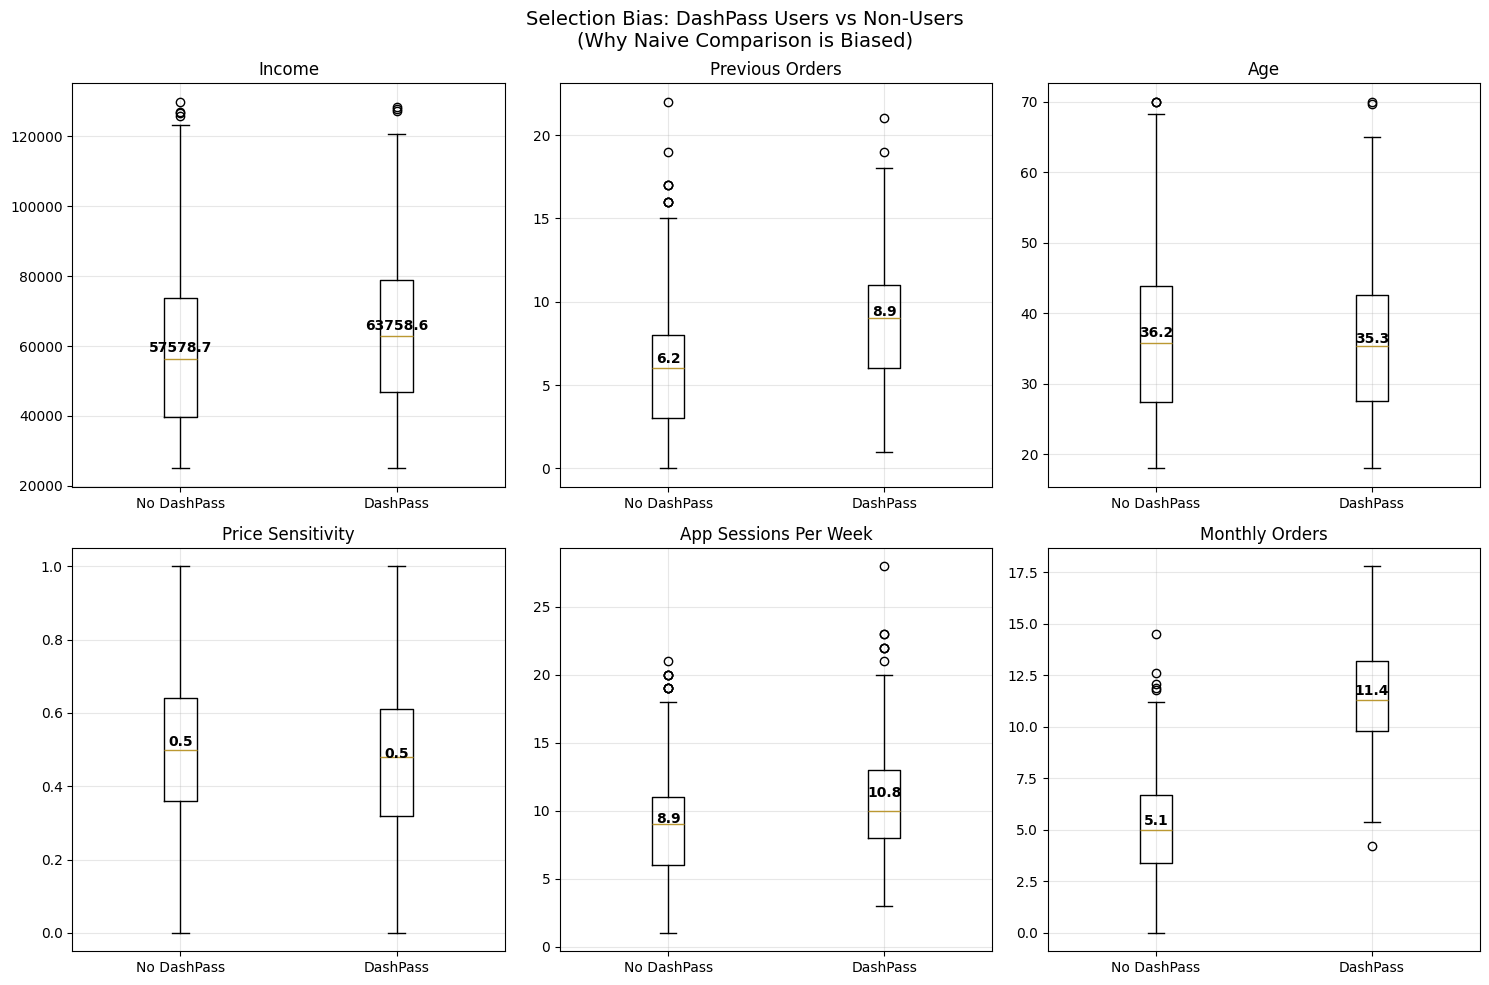

Key Observations:
  📊 DashPass users systematically differ from non-users:
  • Higher income (can afford subscription)
  • More previous orders (benefit more from free delivery)
  • More app engagement (heavy platform users)
  • This creates SELECTION BIAS in naive comparisons!


In [7]:
print("📈 VISUALIZING SELECTION BIAS")
print("=" * 50)

# Create visualizations showing why naive comparison is biased
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Key covariates that differ between groups
covariates_to_plot = ['income', 'previous_orders', 'age', 'price_sensitivity', 'app_sessions_per_week']
outcomes_to_plot = ['monthly_orders']

all_vars = covariates_to_plot + outcomes_to_plot

for i, var in enumerate(all_vars):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Box plots comparing DashPass vs non-DashPass
    data_to_plot = [
        df[df['has_dashpass'] == 0][var],
        df[df['has_dashpass'] == 1][var]
    ]
    
    box_plot = ax.boxplot(data_to_plot, labels=['No DashPass', 'DashPass'])
    ax.set_title(f'{var.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)
    
    # Add mean values as text
    mean_0 = df[df['has_dashpass'] == 0][var].mean()
    mean_1 = df[df['has_dashpass'] == 1][var].mean()
    ax.text(1, mean_0, f'{mean_0:.1f}', ha='center', va='bottom', fontweight='bold')
    ax.text(2, mean_1, f'{mean_1:.1f}', ha='center', va='bottom', fontweight='bold')

# Remove empty subplot
if len(all_vars) < 6:
    fig.delaxes(axes[1, 2])

plt.suptitle('Selection Bias: DashPass Users vs Non-Users\n(Why Naive Comparison is Biased)', fontsize=14)
plt.tight_layout()
plt.show()

print("Key Observations:")
print("  📊 DashPass users systematically differ from non-users:")
print("  • Higher income (can afford subscription)")
print("  • More previous orders (benefit more from free delivery)")  
print("  • More app engagement (heavy platform users)")
print("  • This creates SELECTION BIAS in naive comparisons!")

In [8]:
print("🔍 INITIALIZING PROPENSITY SCORE MATCHING")
print("=" * 50)

# Define covariates for propensity score model
# These should be variables that:
# 1. Predict treatment assignment (DashPass subscription)
# 2. Also affect the outcome (ordering behavior)
# 3. Are measured BEFORE treatment

covariates = [
    # Demographics
    'age', 'income', 'is_urban', 'has_kids', 'is_student',
    
    # Past behavior (pre-treatment)
    'distance_to_restaurant', 'previous_orders', 'days_since_first_order',
    
    # Preferences and engagement
    'app_sessions_per_week', 'prefers_fast_food', 'price_sensitivity'
]

print(f"📋 Covariates for PSM:")
for i, covar in enumerate(covariates, 1):
    print(f"  {i:2d}. {covar}")

# Initialize PSM analysis
psm_analysis = PropensityScoreMatching(
    data=df,
    outcome_var='monthly_orders',  # Primary outcome of interest
    treatment_var='has_dashpass',   # Treatment: DashPass subscription
    covariates=covariates,         # Variables for propensity score
    unit_id='customer_id'          # Customer identifier
)

print("✅ PSM analysis object initialized successfully!")

🔍 INITIALIZING PROPENSITY SCORE MATCHING
📋 Covariates for PSM:
   1. age
   2. income
   3. is_urban
   4. has_kids
   5. is_student
   6. distance_to_restaurant
   7. previous_orders
   8. days_since_first_order
   9. app_sessions_per_week
  10. prefers_fast_food
  11. price_sensitivity
✅ Data validation passed
  - Total observations: 2,000
  - Treatment units: 486
  - Control units: 1,514
  - Covariates: 11
✅ PSM analysis object initialized successfully!


In [9]:
print("🎯 ESTIMATING PROPENSITY SCORES")
print("=" * 50)

# Estimate propensity scores using logistic regression
propensity_scores = psm_analysis.estimate_propensity_scores(
    method='logistic',           # Logistic regression
    include_interactions=False,  # Keep it simple for now
    polynomial_degree=1         # Linear terms only
)

print(f"\n📊 Propensity Score Summary:")
print(f"  • Mean: {propensity_scores.mean():.3f}")
print(f"  • Std Dev: {propensity_scores.std():.3f}")
print(f"  • Min: {propensity_scores.min():.3f}")
print(f"  • Max: {propensity_scores.max():.3f}")


🎯 ESTIMATING PROPENSITY SCORES

PROPENSITY SCORE ESTIMATION
Propensity score estimation complete:
  Method: logistic
  Features used: 11
  AUC: 0.768
  Propensity score range: [0.005, 0.872]
⚠️  Extreme propensity scores detected:
  < 0.1: 523 observations
  > 0.9: 0 observations

📊 Propensity Score Summary:
  • Mean: 0.243
  • Std Dev: 0.180
  • Min: 0.005
  • Max: 0.872


🔍 CHECKING COMMON SUPPORT ASSUMPTION

ASSUMPTION CHECK: COMMON SUPPORT/OVERLAP
Overlap analysis:
  Treatment range: [0.033, 0.852]
  Control range: [0.005, 0.872]
  Overlap range: [0.033, 0.852]
  Observations in overlap: 95.9%
  KS test p-value: 0.000
✅ COMMON SUPPORT: GOOD OVERLAP


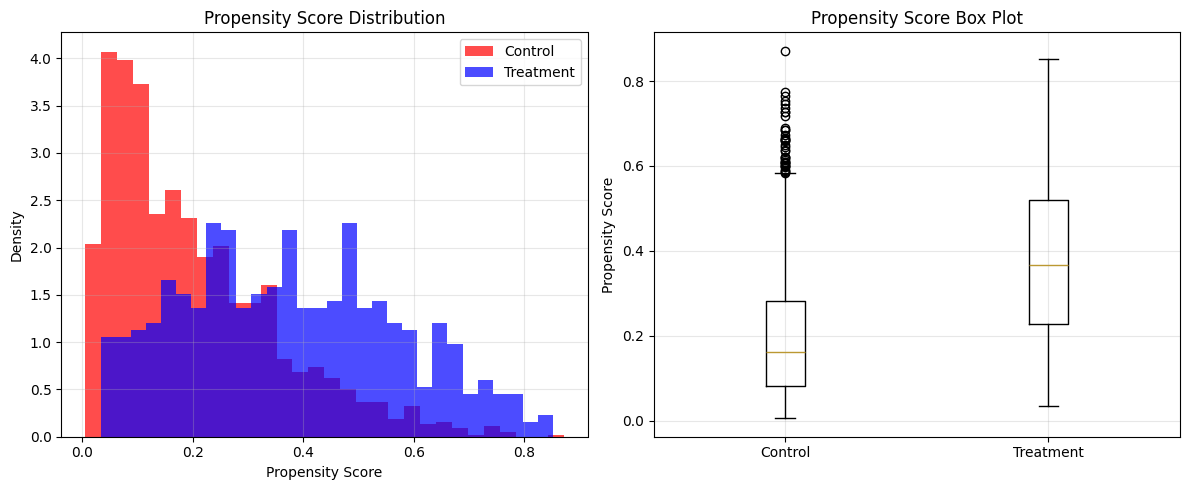


💡 What this means:
  ✅ Good overlap between DashPass and non-DashPass customers
  ✅ We can find comparable customers in both groups


In [10]:
print("🔍 CHECKING COMMON SUPPORT ASSUMPTION")
print("=" * 50)

# Check if treatment and control groups have overlapping propensity scores
overlap_results = psm_analysis.check_overlap(plot=True)

print("\n💡 What this means:")
if overlap_results['assumption_satisfied']:
    print("  ✅ Good overlap between DashPass and non-DashPass customers")
    print("  ✅ We can find comparable customers in both groups")
else:
    print("  ⚠️ Limited overlap - some customers may not have good matches")
    print("  ⚠️ Results may not generalize to all customer types")

In [11]:
print("⚖️ CHECKING COVARIATE BALANCE: BEFORE MATCHING")
print("=" * 50)

# Check how different the groups are before matching
balance_before = psm_analysis.check_balance_before_matching()

print("\n💡 Interpretation:")
print("  • Standardized differences > 0.25 indicate large imbalances")
print("  • We expect to see imbalances BEFORE matching")
print("  • Goal is to reduce these through matching")

# Count severely imbalanced variables
severe_imbalances = sum(1 for var, stats in balance_before.items() 
                       if abs(stats['standardized_diff']) > 0.25)

print(f"\n📊 Balance Summary (Before Matching):")
print(f"  • Variables with severe imbalance: {severe_imbalances}/{len(covariates)}")

⚖️ CHECKING COVARIATE BALANCE: BEFORE MATCHING

COVARIATE BALANCE: BEFORE MATCHING
age                 : Std diff = -0.077, p-value = 0.144
income              : Std diff =  0.270, p-value = 0.000
is_urban            : Std diff =  0.651, p-value = 0.000
has_kids            : Std diff =  0.318, p-value = 0.000
is_student          : Std diff =  0.008, p-value = 0.882
distance_to_restaurant: Std diff = -0.203, p-value = 0.000
previous_orders     : Std diff =  0.775, p-value = 0.000
days_since_first_order: Std diff =  0.015, p-value = 0.774
app_sessions_per_week: Std diff =  0.528, p-value = 0.000
prefers_fast_food   : Std diff = -0.213, p-value = 0.000
price_sensitivity   : Std diff = -0.163, p-value = 0.002

Balance summary:
  Variables with |std diff| > 0.25: 5/11
❌ POOR BALANCE before matching

💡 Interpretation:
  • Standardized differences > 0.25 indicate large imbalances
  • We expect to see imbalances BEFORE matching
  • Goal is to reduce these through matching

📊 Balance Summary (B

In [12]:
print("🎯 PERFORMING PROPENSITY SCORE MATCHING")
print("=" * 50)

# Perform nearest neighbor matching with caliper
matched_data = psm_analysis.perform_matching(
    method='nearest',      # Nearest neighbor matching
    caliper=0.01,         # Maximum propensity score distance (1% caliper)
    replacement=False,     # Each control unit used only once
    ratio=1               # 1:1 matching (1 control per treatment)
)

if matched_data is not None:
    print(f"✅ Matching successful!")
    
    # Show matching results
    treatment_matched = (matched_data['has_dashpass'] == 1).sum()
    control_matched = (matched_data['has_dashpass'] == 0).sum()
    
    print(f"📊 Matched Sample:")
    print(f"  • Treatment units matched: {treatment_matched:,}")
    print(f"  • Control units matched: {control_matched:,}")
    print(f"  • Total matched observations: {len(matched_data):,}")
    print(f"  • Match rate: {treatment_matched/df['has_dashpass'].sum()*100:.1f}% of DashPass users")
else:
    print("❌ Matching failed!")

🎯 PERFORMING PROPENSITY SCORE MATCHING

PROPENSITY SCORE MATCHING: NEAREST
Matching complete:
  Treatment units matched: 422
  Control units matched: 422
  Total matched observations: 844

Match quality assessment:
  Propensity score difference: 0.0002

COVARIATE BALANCE: AFTER MATCHING
age                 : Std diff =  0.045, p-value = 0.509
income              : Std diff = -0.003, p-value = 0.964
is_urban            : Std diff =  0.018, p-value = 0.793
has_kids            : Std diff = -0.014, p-value = 0.836
is_student          : Std diff =  0.048, p-value = 0.484
distance_to_restaurant: Std diff = -0.000, p-value = 0.994
previous_orders     : Std diff =  0.034, p-value = 0.617
days_since_first_order: Std diff = -0.103, p-value = 0.135
app_sessions_per_week: Std diff =  0.020, p-value = 0.777
prefers_fast_food   : Std diff =  0.020, p-value = 0.771
price_sensitivity   : Std diff = -0.026, p-value = 0.707

Balance summary:
  Well-balanced variables (|std diff| < 0.1): 10/11
✅ GOOD BAL

In [13]:
print("⚖️ CHECKING COVARIATE BALANCE: AFTER MATCHING")
print("=" * 50)

# Check if matching improved covariate balance
balance_after = psm_analysis.check_balance_after_matching()

print("\n💡 Interpretation:")
print("  • Good matching should reduce standardized differences")
print("  • Target: |standardized difference| < 0.1 for all variables")

# Compare before vs after
well_balanced_before = sum(1 for var, stats in balance_before.items() 
                          if abs(stats['standardized_diff']) < 0.1)
well_balanced_after = sum(1 for var, stats in balance_after.items() 
                         if abs(stats['standardized_diff']) < 0.1)

print(f"\n📊 Balance Improvement:")
print(f"  • Well-balanced variables before: {well_balanced_before}/{len(covariates)}")
print(f"  • Well-balanced variables after: {well_balanced_after}/{len(covariates)}")
print(f"  • Improvement: {well_balanced_after - well_balanced_before} variables")

⚖️ CHECKING COVARIATE BALANCE: AFTER MATCHING

COVARIATE BALANCE: AFTER MATCHING
age                 : Std diff =  0.045, p-value = 0.509
income              : Std diff = -0.003, p-value = 0.964
is_urban            : Std diff =  0.018, p-value = 0.793
has_kids            : Std diff = -0.014, p-value = 0.836
is_student          : Std diff =  0.048, p-value = 0.484
distance_to_restaurant: Std diff = -0.000, p-value = 0.994
previous_orders     : Std diff =  0.034, p-value = 0.617
days_since_first_order: Std diff = -0.103, p-value = 0.135
app_sessions_per_week: Std diff =  0.020, p-value = 0.777
prefers_fast_food   : Std diff =  0.020, p-value = 0.771
price_sensitivity   : Std diff = -0.026, p-value = 0.707

Balance summary:
  Well-balanced variables (|std diff| < 0.1): 10/11
✅ GOOD BALANCE after matching

💡 Interpretation:
  • Good matching should reduce standardized differences
  • Target: |standardized difference| < 0.1 for all variables

📊 Balance Improvement:
  • Well-balanced variabl

📈 VISUALIZING BALANCE IMPROVEMENT


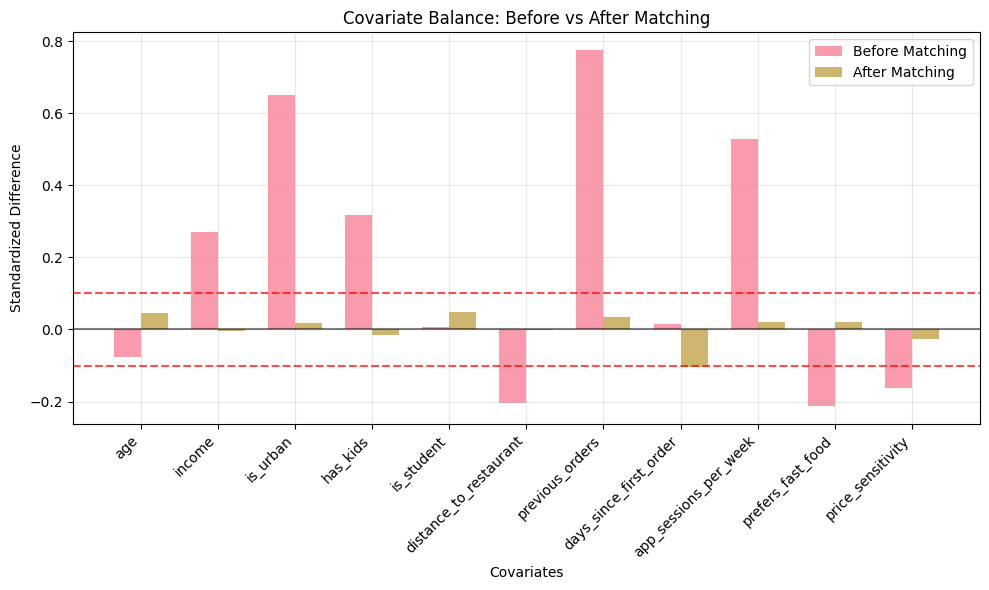

💡 Reading the Plot:
  • Blue bars = balance BEFORE matching
  • Orange bars = balance AFTER matching
  • Red dashed lines = good balance threshold (±0.1)
  • Goal: Orange bars should be smaller and within red lines


In [14]:
print("📈 VISUALIZING BALANCE IMPROVEMENT")
print("=" * 50)

# Create balance plot
psm_analysis.plot_balance()

print("💡 Reading the Plot:")
print("  • Blue bars = balance BEFORE matching")
print("  • Orange bars = balance AFTER matching") 
print("  • Red dashed lines = good balance threshold (±0.1)")
print("  • Goal: Orange bars should be smaller and within red lines")

In [15]:
print("💊 ESTIMATING TREATMENT EFFECT")
print("=" * 50)

# Estimate causal effect on matched sample
treatment_effect = psm_analysis.estimate_treatment_effect(method='simple_difference')

print(f"\n🎯 CAUSAL EFFECT RESULTS:")
print(f"  • ATE (Average Treatment Effect): {treatment_effect['ate']:+.2f} orders/month")
print(f"  • Standard Error: {treatment_effect['standard_error']:.3f}")
print(f"  • 95% Confidence Interval: [{treatment_effect['ci_lower']:.2f}, {treatment_effect['ci_upper']:.2f}]")
print(f"  • P-value: {treatment_effect['p_value']:.3f}")
print(f"  • Effect size: {treatment_effect['effect_percentage']:+.1f}% of control mean")

# Statistical significance
if treatment_effect['p_value'] < 0.05:
    print(f"  ✅ STATISTICALLY SIGNIFICANT at 5% level")
else:
    print(f"  ⚠️ NOT statistically significant at 5% level")

💊 ESTIMATING TREATMENT EFFECT

TREATMENT EFFECT ESTIMATION
Treatment effect estimation:
  Method: simple_difference
  ATE: 4.534
  Standard Error: 0.164
  p-value: 0.000
  95% CI: [4.212, 4.856]
  Effect size: 69.2% of control mean
✅ STATISTICALLY SIGNIFICANT at 5% level

🎯 CAUSAL EFFECT RESULTS:
  • ATE (Average Treatment Effect): +4.53 orders/month
  • Standard Error: 0.164
  • 95% Confidence Interval: [4.21, 4.86]
  • P-value: 0.000
  • Effect size: +69.2% of control mean
  ✅ STATISTICALLY SIGNIFICANT at 5% level


In [16]:
print("📊 BIASED vs UNBIASED ESTIMATES COMPARISON")
print("=" * 50)

# Create comparison
naive_estimate = raw_order_diff
psm_estimate = treatment_effect['ate']
bias = naive_estimate - psm_estimate

print(f"📈 Estimation Comparison:")
print(f"  • Naive estimate (biased): {naive_estimate:+.2f} orders/month")
print(f"  • PSM estimate (unbiased): {psm_estimate:+.2f} orders/month")
print(f"  • Selection bias: {bias:+.2f} orders/month")
print(f"  • Bias magnitude: {abs(bias/psm_estimate)*100:.1f}% of true effect")

print(f"\n💡 Interpretation:")
if abs(bias) > 0.5:
    print(f"  🚨 LARGE SELECTION BIAS detected!")
    print(f"  🚨 Naive comparison {'overestimates' if bias > 0 else 'underestimates'} true effect")
else:
    print(f"  ✅ Selection bias is relatively small")

📊 BIASED vs UNBIASED ESTIMATES COMPARISON
📈 Estimation Comparison:
  • Naive estimate (biased): +6.31 orders/month
  • PSM estimate (unbiased): +4.53 orders/month
  • Selection bias: +1.78 orders/month
  • Bias magnitude: 39.2% of true effect

💡 Interpretation:
  🚨 LARGE SELECTION BIAS detected!
  🚨 Naive comparison overestimates true effect


In [17]:
print("💰 ANALYZING ALTERNATIVE OUTCOMES")
print("=" * 50)

# Test effect on other outcomes
outcomes_to_test = {
    'avg_order_value': 'Average Order Value ($)',
    'monthly_spending': 'Monthly Spending ($)',
    'customer_satisfaction': 'Customer Satisfaction (1-5)'
}

alternative_results = {}

for outcome_var, outcome_label in outcomes_to_test.items():
    print(f"\n📊 Effect on {outcome_label}:")
    
    # Create separate PSM analysis for this outcome
    alt_psm = PropensityScoreMatching(
        data=df,
        outcome_var=outcome_var,
        treatment_var='has_dashpass',
        covariates=covariates,
        unit_id='customer_id'
    )
    
    # Use same propensity scores and matched data structure
    alt_psm.propensity_scores = psm_analysis.propensity_scores
    alt_psm.data['propensity_score'] = psm_analysis.propensity_scores
    alt_psm.matched_data = matched_data  # Use same matched pairs
    
    # Estimate effect
    alt_effect = alt_psm.estimate_treatment_effect(method='simple_difference')
    alternative_results[outcome_var] = alt_effect
    
    print(f"  • Effect: {alt_effect['ate']:+.2f}")
    print(f"  • P-value: {alt_effect['p_value']:.3f}")
    print(f"  • Significant: {'Yes' if alt_effect['p_value'] < 0.05 else 'No'}")

💰 ANALYZING ALTERNATIVE OUTCOMES

📊 Effect on Average Order Value ($):
✅ Data validation passed
  - Total observations: 2,000
  - Treatment units: 486
  - Control units: 1,514
  - Covariates: 11

TREATMENT EFFECT ESTIMATION
Treatment effect estimation:
  Method: simple_difference
  ATE: 0.374
  Standard Error: 0.430
  p-value: 0.384
  95% CI: [-0.468, 1.217]
  Effect size: 1.1% of control mean
⚠️ NOT STATISTICALLY SIGNIFICANT at 5% level
  • Effect: +0.37
  • P-value: 0.384
  • Significant: No

📊 Effect on Monthly Spending ($):
✅ Data validation passed
  - Total observations: 2,000
  - Treatment units: 486
  - Control units: 1,514
  - Covariates: 11

TREATMENT EFFECT ESTIMATION
Treatment effect estimation:
  Method: simple_difference
  ATE: 165.483
  Standard Error: 7.185
  p-value: 0.000
  95% CI: [151.400, 179.566]
  Effect size: 70.8% of control mean
✅ STATISTICALLY SIGNIFICANT at 5% level
  • Effect: +165.48
  • P-value: 0.000
  • Significant: Yes

📊 Effect on Customer Satisfaction

In [18]:
print("🧪 ROBUSTNESS CHECKS")
print("=" * 50)

# Placebo test
print("1️⃣ PLACEBO TEST:")
placebo_results = psm_analysis.placebo_test()

# Sensitivity analysis  
print("\n2️⃣ SENSITIVITY ANALYSIS:")
sensitivity_results = psm_analysis.sensitivity_analysis()

print(f"\n🔍 Robustness Summary:")
placebo_passed = placebo_results['test_passed']
print(f"  • Placebo test: {'✅ PASSED' if placebo_passed else '⚠️ FAILED'}")
print(f"  • Sensitivity analysis: See detailed output above")

🧪 ROBUSTNESS CHECKS
1️⃣ PLACEBO TEST:

ROBUSTNESS CHECK: PLACEBO TEST
Placebo test (permuted treatment):
  Placebo effect: -0.042
  p-value: 0.854
✅ PLACEBO TEST PASSED

2️⃣ SENSITIVITY ANALYSIS:

SENSITIVITY ANALYSIS: HIDDEN BIAS
Note: This is a simplified sensitivity analysis.
Full Rosenbaum bounds require specialized implementation.
Sensitivity to hidden bias (Γ = degree of hidden bias):
  Γ = 1.0: Effect = 4.534 (+0.0%)
  Γ = 1.1: Effect = 4.122 (+9.1%)
  Γ = 1.2: Effect = 3.778 (+16.7%)
  Γ = 1.3: Effect = 3.488 (+23.1%)
  Γ = 1.4: Effect = 3.239 (+28.6%)
  Γ = 1.5: Effect = 3.023 (+33.3%)

🔍 Robustness Summary:
  • Placebo test: ✅ PASSED
  • Sensitivity analysis: See detailed output above


In [19]:
print("💼 BUSINESS INTERPRETATION & RECOMMENDATIONS")
print("=" * 60)

# Extract key results for business interpretation
orders_effect = treatment_effect['ate']
orders_pvalue = treatment_effect['p_value']
aov_effect = alternative_results['avg_order_value']['ate']
spending_effect = alternative_results['monthly_spending']['ate']
satisfaction_effect = alternative_results['customer_satisfaction']['ate']

print(f"🎯 KEY FINDINGS:")
print(f"  📦 Order Frequency Impact: {orders_effect:+.1f} orders/month")
print(f"      • Statistical significance: {'Yes' if orders_pvalue < 0.05 else 'No'} (p={orders_pvalue:.3f})")
print(f"      • Effect size: {treatment_effect['effect_percentage']:+.1f}% increase")

print(f"\n  💰 Order Value Impact: ${aov_effect:+.2f} per order")
print(f"      • Statistical significance: {'Yes' if alternative_results['avg_order_value']['p_value'] < 0.05 else 'No'}")

print(f"\n  💵 Total Spending Impact: ${spending_effect:+.2f}/month")
print(f"      • Statistical significance: {'Yes' if alternative_results['monthly_spending']['p_value'] < 0.05 else 'No'}")

print(f"\n  😊 Satisfaction Impact: {satisfaction_effect:+.2f} points (1-5 scale)")
print(f"      • Statistical significance: {'Yes' if alternative_results['customer_satisfaction']['p_value'] < 0.05 else 'No'}")

# Business metrics calculation
dashpass_price = 9.99  # Assume $9.99/month subscription
additional_revenue = spending_effect
net_revenue_impact = additional_revenue - 0  # Assume no additional costs

print(f"\n💼 BUSINESS IMPACT:")
if orders_pvalue < 0.05 and orders_effect > 0:
    print(f"  ✅ DashPass significantly increases customer ordering")
    print(f"  📈 Additional monthly revenue per customer: ${spending_effect:+.2f}")
    
    if spending_effect > 3:  # Arbitrary threshold
        print(f"  💰 Strong positive ROI - DashPass drives meaningful revenue growth")
        print(f"  🚀 Recommendation: Expand DashPass marketing and enrollment")
    else:
        print(f"  📊 Moderate impact - continue monitoring and optimization")
        
elif orders_pvalue >= 0.05:
    print(f"  ⚠️ No statistically significant impact on order frequency")
    print(f"  🤔 Recommendation: Investigate why DashPass isn't driving orders")
    print(f"      • Are benefits compelling enough?")
    print(f"      • Is pricing optimal?")
    print(f"      • Are there customer education opportunities?")

print(f"\n🔍 METHODOLOGY QUALITY:")
overlap_ok = psm_analysis.assumption_checks.get('overlap', {}).get('assumption_satisfied', False)
print(f"  • Common support: {'✅ Good' if overlap_ok else '⚠️ Poor'}")
print(f"  • Balance improvement: {well_balanced_after}/{len(covariates)} variables well-balanced")
print(f"  • Placebo test: {'✅ Passed' if placebo_passed else '⚠️ Failed'}")

print(f"\n📋 NEXT STEPS:")
print("  1. Segment analysis - which customer types benefit most?")
print("  2. Long-term effects - does impact persist over time?") 
print("  3. Price optimization - test different DashPass pricing")
print("  4. Feature enhancement - what additional benefits would help?")
print("  5. Competitive analysis - how does this compare to UberEats One?")

💼 BUSINESS INTERPRETATION & RECOMMENDATIONS
🎯 KEY FINDINGS:
  📦 Order Frequency Impact: +4.5 orders/month
      • Statistical significance: Yes (p=0.000)
      • Effect size: +69.2% increase

  💰 Order Value Impact: $+0.37 per order
      • Statistical significance: No

  💵 Total Spending Impact: $+165.48/month
      • Statistical significance: Yes

  😊 Satisfaction Impact: +0.28 points (1-5 scale)
      • Statistical significance: Yes

💼 BUSINESS IMPACT:
  ✅ DashPass significantly increases customer ordering
  📈 Additional monthly revenue per customer: $+165.48
  💰 Strong positive ROI - DashPass drives meaningful revenue growth
  🚀 Recommendation: Expand DashPass marketing and enrollment

🔍 METHODOLOGY QUALITY:
  • Common support: ✅ Good
  • Balance improvement: 10/11 variables well-balanced
  • Placebo test: ✅ Passed

📋 NEXT STEPS:
  1. Segment analysis - which customer types benefit most?
  2. Long-term effects - does impact persist over time?
  3. Price optimization - test differen

In [20]:
print("💾 SAVING ANALYSIS RESULTS")
print("=" * 30)

# Create comprehensive results summary
results_summary = pd.DataFrame({
    'Outcome': ['Monthly Orders', 'Average Order Value', 'Monthly Spending', 'Customer Satisfaction'],
    'Treatment_Effect': [
        orders_effect,
        aov_effect, 
        spending_effect,
        satisfaction_effect
    ],
    'P_Value': [
        orders_pvalue,
        alternative_results['avg_order_value']['p_value'],
        alternative_results['monthly_spending']['p_value'],
        alternative_results['customer_satisfaction']['p_value']
    ],
    'Significant': [
        orders_pvalue < 0.05,
        alternative_results['avg_order_value']['p_value'] < 0.05,
        alternative_results['monthly_spending']['p_value'] < 0.05,
        alternative_results['customer_satisfaction']['p_value'] < 0.05
    ],
    'CI_Lower': [
        treatment_effect['ci_lower'],
        alternative_results['avg_order_value']['ci_lower'],
        alternative_results['monthly_spending']['ci_lower'],
        alternative_results['customer_satisfaction']['ci_lower']
    ],
    'CI_Upper': [
        treatment_effect['ci_upper'],
        alternative_results['avg_order_value']['ci_upper'],
        alternative_results['monthly_spending']['ci_upper'],
        alternative_results['customer_satisfaction']['ci_upper']
    ]
})

print("📊 Final Results Summary:")
display(results_summary)

# Save datasets and results
# results_summary.to_csv('doordash_psm_results.csv', index=False)
# df.to_csv('doordash_customer_data.csv', index=False)
# if matched_data is not None:
#     matched_data.to_csv('doordash_matched_data.csv', index=False)

💾 SAVING ANALYSIS RESULTS
📊 Final Results Summary:


,Outcome,Treatment_Effect,P_Value,Significant,CI_Lower,CI_Upper
0,Monthly Orders,4.534123,6.437253e-120,True,4.212106,4.856141
1,Average Order Value,0.374455,3.837608e-01,False,-0.467748,1.216658
2,Monthly Spending,165.482725,2.078437e-91,True,151.399746,179.565704
3,Customer Satisfaction,0.275355,1.700213e-11,True,0.196259,0.354452
